In [1]:
import gc
import os
import random
from typing import List, Tuple

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_covtype
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import Binarizer, KBinsDiscretizer
from tqdm.notebook import tqdm

In [4]:
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_probability as tfp

In [5]:
def build_preprocessor(X: np.ndarray, colnames: List[str]) -> Tuple[Pipeline, List[str], \
                                                                    List[int]]:
    X_ = Pipeline(steps=[
        (
            'imputer', SimpleImputer(
                missing_values=np.nan, strategy='constant',
                fill_value=-1.0
            )
        ),
        (
            'scaler',
            MinMaxScaler()
        )
    ]).fit_transform(X)
    X_ = np.rint(X_ * 100000.0).astype(np.int32)
    binary_features = dict()
    categorical_features = dict()
    removed_features = []
    for col_idx in range(X.shape[1]):
        values = set(X_[:, col_idx].tolist())
        print(f'Column {col_idx} "{colnames[col_idx]}" has ' \
              f'{len(values)} unique values.')
        if len(values) > 1:
            if len(values) < 3:
                binary_features[col_idx] = np.min(X[:, col_idx])
            else:
                categorical_features[col_idx] = len(values)
        else:
            removed_features.append(col_idx)
        del values
    del X_
    all_features = set(range(X.shape[1]))
    useful_features = sorted(list(all_features - set(removed_features)))
    if len(useful_features) == 0:
        raise ValueError('Training inputs are bad. All features are removed.')
    print(f'There are {X.shape[1]} features.')
    if len(removed_features) > 0:
        print(f'These features will be removed: ' \
              f'{[colnames[col_idx] for col_idx in removed_features]}.')
    transformers = []
    if (len(categorical_features) > 0) and (len(binary_features) > 0):
        print(f'There are {len(categorical_features)} categorical ' \
              f'features and {len(binary_features)} binary features.')
    elif len(categorical_features) > 0:
        print(f'There are {len(categorical_features)} categorical features.')
    else:
        print(f'There are {len(binary_features)} binary features.')
    source_features = []
    for col_idx in categorical_features:
        n_unique_values = categorical_features[col_idx]
        transformers.append(
            (
                colnames[col_idx],
                KBinsDiscretizer(
                    n_bins=min(max(n_unique_values // 3, 3), 256),
                    encode='ordinal',
                    strategy=('quantile' if n_unique_values > 50 else 'kmeans')
                ),
                (col_idx,)
            )
        )
        source_features.append(colnames[col_idx])
    for col_idx in binary_features:
        transformers.append(
            (
                colnames[col_idx],
                Binarizer(threshold=0.0),
                (col_idx,)
            )
        )
        source_features.append(colnames[col_idx])
    preprocessor = Pipeline(steps=[
        (
            'imputer', SimpleImputer(
                missing_values=np.nan, strategy='constant',
                fill_value=-1.0
            )
        ),
        (
            'minmax_scaler',
            MinMaxScaler()
        ),
        (
            'composite_transformer', ColumnTransformer(
                transformers=transformers,
                sparse_threshold=0.0,
                n_jobs=1
            )
        ),
        (
            'selector',
            VarianceThreshold()
        )
    ])
    preprocessor.fit(X)
    mask = preprocessor.named_steps['selector'].get_support(indices=False)
    assert len(mask) == len(source_features)
    selected_features = list(map(
        lambda idx2: source_features[idx2],
        filter(lambda idx1: mask[idx1], range(len(mask)))
    ))
    X_trans = preprocessor.transform(X)
    assert X_trans.shape[1] == len(selected_features)
    unique_values_list = []
    for ft_idx in range(X_trans.shape[1]):
        unique_values = set(map(lambda it: int(it), X_trans[:, ft_idx].tolist()))
        n_unique_values = len(unique_values)
        assert n_unique_values > 1
        unique_values_list.append(n_unique_values)
    return preprocessor, selected_features, unique_values_list

In [6]:
def build_normalizer(X: np.ndarray) -> Pipeline:
    normalizer = Pipeline(steps=[
        (
            'imputer',
            SimpleImputer(missing_values=np.nan, strategy='mean')
        ),
        (
            'standard_scaler',
            StandardScaler(with_mean=True, with_std=True)
        ),
        (
            'pca',
            PCA(random_state=42)
        )
    ])
    return normalizer.fit(X)

In [7]:
def build_neural_network(features: List[int], n_classes: int,
                         n_latent: int, n_hidden: int, depth: int,
                         dropout_rate: float,
                         nn_name: str) -> Tuple[tf.keras.Model, tf.keras.Model, \
                                                tf.keras.Model]:
    if n_hidden < 1:
        err_msg = f'The hidde layer size = {n_hidden} is too small!'
    binary_ft_indices = set()
    for ft_idx, ft_size in enumerate(features):
        if ft_size < 2:
            err_msg = f'Feature {ft_idx} unique values quanity = {ft_size} is too small!'
            raise ValueError(err_msg)
        if ft_size == 2:
            binary_ft_indices.add(ft_idx)
    if (len(binary_ft_indices) > 0) and (len(binary_ft_indices) < len(features)):
        info_msg = f'There are {len(binary_ft_indices)} binary features and ' \
                   f'{len(features) - len(binary_ft_indices)} categorical features.'
    elif len(binary_ft_indices) > 0:
        info_msg = f'There are {len(binary_ft_indices)} binary features.'
    else:
        info_msg = f'There are {len(features)} categorical features.'
    print(info_msg)
    feature_vector = tf.keras.layers.Input(
        shape=(len(features),), dtype=tf.float32,
        name=f'{nn_name}_feature_vector'
    )
    encoder_layer = tf.keras.layers.AlphaDropout(
        rate=dropout_rate,
        seed=random.randint(0, 2147483647),
        name=f'{nn_name}_enc_dropout1'
    )(feature_vector)
    try:
        kernel_initializer = tf.keras.initializers.LecunNormal(
            seed=random.randint(0, 2147483647)
        )
    except:
        kernel_initializer = tf.compat.v1.keras.initializers.lecun_normal(
            seed=random.randint(0, 2147483647)
        )
    encoder_layer = tf.keras.layers.Dense(
        units=n_hidden,
        activation='selu',
        kernel_initializer=kernel_initializer,
        bias_initializer='zeros',
        name=f'{nn_name}_enc_dense1'
    )(encoder_layer)
    for layer_idx in range(1, depth):
        encoder_layer = tf.keras.layers.AlphaDropout(
            rate=dropout_rate,
            seed=random.randint(0, 2147483647),
            name=f'{nn_name}_enc_dropout{layer_idx + 1}'
        )(encoder_layer)
        try:
            kernel_initializer = tf.keras.initializers.LecunNormal(
                seed=random.randint(0, 2147483647)
            )
        except:
            kernel_initializer = tf.compat.v1.keras.initializers.lecun_normal(
                seed=random.randint(0, 2147483647)
            )
        encoder_layer = tf.keras.layers.Dense(
            units=n_hidden,
            activation='selu',
            kernel_initializer=kernel_initializer,
            bias_initializer='zeros',
            name=f'{nn_name}_enc_dense{layer_idx + 1}'
        )(encoder_layer)
    prior = tfp.distributions.Independent(
        distribution=tfp.distributions.Normal(
            loc=tf.zeros(n_latent),
            scale=1
        ),
        reinterpreted_batch_ndims=1
    )
    try:
        kernel_initializer = tf.keras.initializers.LecunNormal(
            seed=random.randint(0, 2147483647)
        )
    except:
        kernel_initializer = tf.compat.v1.keras.initializers.lecun_normal(
            seed=random.randint(0, 2147483647)
        )
    latent_layer = tf.keras.layers.Dense(
        units=tfp.layers.IndependentNormal.params_size(n_latent),
        activation=None,
        kernel_initializer=kernel_initializer,
        bias_initializer='zeros',
        name=f'{nn_name}_latent'
    )(encoder_layer)
    z = tfp.layers.IndependentNormal(
        event_shape=n_latent,
        convert_to_tensor_fn=tfp.distributions.Distribution.sample,
        activity_regularizer=tfp.layers.KLDivergenceRegularizer(
            distribution_b=prior,
            weight=1e-3
        ),
        name=f'{nn_name}_z'
    )(latent_layer)
    classifier_input = tf.keras.layers.Input(
        shape=(n_latent,), dtype=tf.float32,
        name=f'{nn_name}_feature_vector'
    )
    try:
        kernel_initializer = tf.keras.initializers.LecunNormal(
            seed=random.randint(0, 2147483647)
        )
    except:
        kernel_initializer = tf.compat.v1.keras.initializers.lecun_normal(
            seed=random.randint(0, 2147483647)
        )
    hidden_layer = tf.keras.layers.Dense(
        units=n_hidden,
        activation='selu',
        kernel_initializer=kernel_initializer,
        bias_initializer='zeros',
        name=f'{nn_name}_cls_hidden'
    )(classifier_input)
    hidden_layer = tf.keras.layers.AlphaDropout(
        rate=dropout_rate,
        seed=random.randint(0, 2147483647),
        name=f'{nn_name}_cls_dropout'
    )(hidden_layer)
    cls_layer = tf.keras.layers.Dense(
        units=n_classes,
        activation='softmax',
        kernel_initializer=kernel_initializer,
        bias_initializer='zeros',
        name=f'{nn_name}_cls_output'
    )(hidden_layer)
    cls_name = f'{nn_name}_cls'
    cls_model = tf.keras.Model(
        inputs=classifier_input,
        outputs=cls_layer,
        name=cls_name
    )
    cls_model.build(input_shape=[None, n_latent])
    decoder_layer = tf.keras.layers.AlphaDropout(
        rate=dropout_rate,
        seed=random.randint(0, 2147483647),
        name=f'{nn_name}_dec_dropout1'
    )(z)
    try:
        kernel_initializer = tf.keras.initializers.LecunNormal(
            seed=random.randint(0, 2147483647)
        )
    except:
        kernel_initializer = tf.compat.v1.keras.initializers.lecun_normal(
            seed=random.randint(0, 2147483647)
        )
    decoder_layer = tf.keras.layers.Dense(
        units=n_hidden,
        activation='selu',
        kernel_initializer=kernel_initializer,
        bias_initializer='zeros',
        name=f'{nn_name}_dec_dense1'
    )(decoder_layer)
    for layer_idx in range(1, depth):
        decoder_layer = tf.keras.layers.AlphaDropout(
            rate=dropout_rate,
            seed=random.randint(0, 2147483647),
            name=f'{nn_name}_dec_dropout{layer_idx + 1}'
        )(decoder_layer)
        try:
            kernel_initializer = tf.keras.initializers.LecunNormal(
                seed=random.randint(0, 2147483647)
            )
        except:
            kernel_initializer = tf.compat.v1.keras.initializers.lecun_normal(
                seed=random.randint(0, 2147483647)
            )
        decoder_layer = tf.keras.layers.Dense(
            units=n_hidden,
            activation='selu',
            kernel_initializer=kernel_initializer,
            bias_initializer='zeros',
            name=f'{nn_name}_dec_dense{layer_idx + 1}'
        )(decoder_layer)
    reconstruction_layers = []
    reconstruction_names = []
    if len(binary_ft_indices) > 0:
        try:
            kernel_initializer = tf.keras.initializers.LecunNormal(
                seed=random.randint(0, 2147483647)
            )
        except:
            kernel_initializer = tf.compat.v1.keras.initializers.lecun_normal(
                seed=random.randint(0, 2147483647)
            )
        new_reconstruction_layer = tf.keras.layers.Dense(
            units=len(binary_ft_indices),
            activation=None,
            kernel_initializer=kernel_initializer,
            bias_initializer='zeros',
            name=f'{nn_name}_rec_binary'
        )(decoder_layer)
        new_reconstruction_name = f'{nn_name}_bernoulli'
        new_reconstruction_layer = tfp.layers.IndependentBernoulli(
            event_shape=len(binary_ft_indices),
            convert_to_tensor_fn=tfp.distributions.Bernoulli.logits,
            name=new_reconstruction_name
        )(new_reconstruction_layer)
        reconstruction_layers.append(new_reconstruction_layer)
        reconstruction_names.append(new_reconstruction_name)
    counter = 1
    for ft_idx, ft_size in enumerate(features):
        if ft_size > 2:
            try:
                kernel_initializer = tf.keras.initializers.LecunNormal(
                    seed=random.randint(0, 2147483647)
                )
            except:
                kernel_initializer = tf.compat.v1.keras.initializers.lecun_normal(
                    seed=random.randint(0, 2147483647)
                )
            new_reconstruction_layer = tf.keras.layers.Dense(
                units=ft_size,
                activation=None,
                kernel_initializer=kernel_initializer,
                bias_initializer='zeros',
                name=f'{nn_name}_rec_cat{counter}'
            )(decoder_layer)
            new_reconstruction_name = f'{nn_name}_categorical{counter}'
            new_reconstruction_layer = tfp.layers.OneHotCategorical(
                event_size=ft_size,
                convert_to_tensor_fn=tfp.distributions.OneHotCategorical.logits,
                name=new_reconstruction_name
            )(new_reconstruction_layer)
            reconstruction_layers.append(new_reconstruction_layer)
            reconstruction_names.append(new_reconstruction_name)
            counter += 1
    encoder_model = tf.keras.Model(
        inputs=feature_vector,
        outputs=z,
        name=f'{nn_name}_enc'
    )
    united_model = tf.keras.Model(
        inputs=feature_vector,
        outputs=[cls_model(z)] + reconstruction_layers,
        name=f'{nn_name}_vae'
    )
    encoder_model.build(input_shape=[None, len(features)])
    metrics = {cls_name: [tf.keras.metrics.CategoricalAccuracy()]}
    negloglik = lambda y, rv_y: -rv_y.log_prob(y)
    losses = {
        cls_name: tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05)
    }
    loss_weights = {
        cls_name: 1.0
    }
    for cur_name in reconstruction_names:
        losses[cur_name] = negloglik
        loss_weights[cur_name] = 0.5
    radam = tfa.optimizers.RectifiedAdam(learning_rate=1e-4)
    ranger = tfa.optimizers.Lookahead(radam, sync_period=6, slow_step_size=0.5)
    united_model.compile(optimizer=ranger, loss=losses, loss_weights=loss_weights,
                         metrics=metrics)
    return united_model, encoder_model, cls_model

In [8]:
def calculate_projections(X: np.ndarray, encoder: tf.keras.Model,
                          n_samples: int, batch_size: int) -> List[np.ndarray]:
    n_batches = int(np.ceil(X.shape[0] / float(batch_size)))
    projections = [[] for _ in range(n_samples)]
    for batch_idx in tqdm(list(range(n_batches))):
        batch_start = batch_idx * batch_size
        batch_end = min(X.shape[0], batch_start + batch_size)
        distr = encoder(X[batch_start:batch_end])
        assert isinstance(distr, tfp.distributions.Distribution)
        y_inst = distr.sample()
        if not isinstance(y_inst, np.ndarray):
            y_inst = y_inst.numpy()
        assert len(y_inst.shape) == 2
        projections[0].append(y_inst)
        del y_inst
        for prj_idx in range(1, n_samples):
            y_inst = distr.sample()
            if not isinstance(y_inst, np.ndarray):
                y_inst = y_inst.numpy()
            assert len(y_inst.shape) == 2
            projections[prj_idx].append(y_inst)
            del y_inst
        del distr
    return [np.vstack(cur) for cur in projections]

In [9]:
def predict_proba(X: np.ndarray, encoder: tf.keras.Model, classifier: tf.keras.Model,
                  n_samples: int, batch_size: int) -> np.ndarray:
    projections = calculate_projections(X, encoder, n_samples, batch_size)
    y = classifier.predict(projections[0], batch_size=batch_size)
    assert len(y.shape) == 2
    for prj_idx in range(1, n_samples):
        y += classifier.predict(projections[prj_idx], batch_size=batch_size)
    proba = y.astype(np.float64) / float(n_samples)
    return proba / np.sum(proba, axis=1, keepdims=True)

In [10]:
class TrainsetGenerator(tf.keras.utils.Sequence):
    def __init__(self, x_src: np.ndarray, x_norm: np.ndarray, y: np.ndarray,
                 n_classes: int, batch_size: int, features: List[int]):
        self.x_src, self.x_norm, self.y = x_src, x_norm, y
        self.batch_size = batch_size
        self.features = features
        self.n_classes = n_classes
        self.indices_ = np.array(list(range(self.x_src.shape[0])), dtype=np.int32)
        self.binary_feature_list_ = []
        self.cat_feature_list_ = []
        for ft_idx, ft_size in enumerate(self.features):
            if ft_size < 2:
                err_msg = f'Feature {ft_idx} unique values quanity = {ft_size} ' \
                          f'is too small!'
                raise ValueError(err_msg)
            if ft_size == 2:
                self.binary_feature_list_.append(ft_idx)
            else:
                self.cat_feature_list_.append(ft_idx)
        self.class_distr_ = dict()
        for sample_idx, class_idx in enumerate(y.tolist()):
            if class_idx in self.class_distr_:
                self.class_distr_[class_idx].append(sample_idx)
            else:
                self.class_distr_[class_idx] = [sample_idx]
        for class_idx in self.class_distr_:
            self.class_distr_[class_idx] = np.array(self.class_distr_[class_idx],
                                                    dtype=np.int32)
        assert len(self.x_src.shape) == 2
        assert self.x_src.shape[0] > self.batch_size
        assert self.x_norm.shape == self.x_src.shape
        assert len(self.y.shape) == 1
        assert self.y.shape[0] == self.x_src.shape[0]
        assert self.x_src.shape[1] == len(self.features)
    
    def __len__(self):
        return int(np.ceil(self.x_src.shape[0] / float(self.batch_size)))
    
    def __getitem__(self, batch_idx: int):
        batch_indices = []
        selected_classes = sorted(list(self.class_distr_.keys()))
        if self.batch_size < len(selected_classes):
            selected_classes = random.sample(selected_classes, self.batch_size)
        for counter, class_idx in enumerate(selected_classes):
            n = int(round(
                (self.batch_size - len(batch_indices)) / 
                (len(selected_classes) - counter)
            ))
            batch_indices += np.random.choice(
                a=self.class_distr_[class_idx],
                size=n
            ).tolist()
        X_batch = np.empty((len(batch_indices), len(self.features)), dtype=np.float32)
        y_batch = [
            np.zeros((len(batch_indices), self.n_classes), dtype=np.float32),
        ]
        if len(self.binary_feature_list_) > 0:
            y_batch.append(
                np.zeros(
                    (len(batch_indices), len(self.binary_feature_list_)),
                    dtype=np.float32
                )
            )
        for ft_idx in self.cat_feature_list_:
            y_batch.append(
                np.zeros(
                    (len(batch_indices), self.features[ft_idx]),
                    dtype=np.float32
                )
            )
        for idx, sample_idx in enumerate(batch_indices):
            X_batch[idx] = self.x_norm[sample_idx]
            class_idx = self.y[sample_idx]
            y_batch[0][idx, class_idx] = 1.0
            counter = 1
            if len(self.binary_feature_list_) > 0:
                for col_idx, ft_idx in enumerate(self.binary_feature_list_):
                    class_idx = int(self.x_src[sample_idx, ft_idx])
                    if class_idx > 0:
                        y_batch[1][idx, col_idx] = 1.0
                counter += 1
            for ft_idx in self.cat_feature_list_:
                class_idx = int(self.x_src[sample_idx, ft_idx])
                y_batch[counter][idx, class_idx] = 1.0
                counter += 1
        return X_batch, y_batch

In [11]:
class ValidsetGenerator(tf.keras.utils.Sequence):
    def __init__(self, x_src: np.ndarray, x_norm: np.ndarray, y: np.ndarray,
                 n_classes: int, batch_size: int, features: List[int]):
        self.x_src, self.x_norm, self.y = x_src, x_norm, y
        self.batch_size = batch_size
        self.features = features
        self.n_classes = n_classes
        self.indices_ = np.array(list(range(self.x_src.shape[0])), dtype=np.int32)
        self.binary_feature_list_ = []
        self.cat_feature_list_ = []
        for ft_idx, ft_size in enumerate(self.features):
            if ft_size < 2:
                err_msg = f'Feature {ft_idx} unique values quanity = {ft_size} ' \
                          f'is too small!'
                raise ValueError(err_msg)
            if ft_size == 2:
                self.binary_feature_list_.append(ft_idx)
            else:
                self.cat_feature_list_.append(ft_idx)
        assert len(self.x_src.shape) == 2
        assert self.x_src.shape[0] > self.batch_size
        assert self.x_norm.shape == self.x_src.shape
        assert len(self.y.shape) == 1
        assert self.y.shape[0] == self.x_src.shape[0]
        assert self.x_src.shape[1] == len(self.features)
    
    def __len__(self):
        return int(np.ceil(self.x_src.shape[0] / float(self.batch_size)))
    
    def __getitem__(self, batch_idx: int):
        batch_start = batch_idx * self.batch_size
        batch_end = min(batch_start + self.batch_size, self.x_src.shape[0])
        batch_indices = list(range(batch_start, batch_end))
        X_batch = np.empty((len(batch_indices), len(self.features)), dtype=np.float32)
        y_batch = [
            np.zeros((len(batch_indices), self.n_classes), dtype=np.float32),
        ]
        if len(self.binary_feature_list_) > 0:
            y_batch.append(
                np.zeros(
                    (len(batch_indices), len(self.binary_feature_list_)),
                    dtype=np.float32
                )
            )
        for ft_idx in self.cat_feature_list_:
            y_batch.append(
                np.zeros(
                    (len(batch_indices), self.features[ft_idx]),
                    dtype=np.float32
                )
            )
        for idx, sample_idx in enumerate(batch_indices):
            X_batch[idx] = self.x_norm[sample_idx]
            class_idx = self.y[sample_idx]
            y_batch[0][idx, class_idx] = 1.0
            counter = 1
            if len(self.binary_feature_list_) > 0:
                for col_idx, ft_idx in enumerate(self.binary_feature_list_):
                    class_idx = int(self.x_src[sample_idx, ft_idx])
                    if class_idx > 0:
                        y_batch[1][idx, col_idx] = 1.0
                counter += 1
            for ft_idx in self.cat_feature_list_:
                class_idx = int(self.x_src[sample_idx, ft_idx])
                y_batch[counter][idx, class_idx] = 1.0
                counter += 1
        return X_batch, y_batch

In [12]:
def show_training_process(history: tf.keras.callbacks.History, metric_name: str,
                          figure_id: int=1, comment: str=''):
    val_metric_name = 'val_' + metric_name
    if metric_name not in history.history:
        err_msg = f'The metric "{metric_name}" is not found! Available metrics are: ' \
                  f'{list(history.history.keys())}.'
        raise ValueError(err_msg)
    plt.figure(figure_id, figsize=(5, 5))
    interesting_metric = history.history[metric_name]
    plt.plot(list(range(len(interesting_metric))), interesting_metric,
             label=f'Training {metric_name}')
    if val_metric_name in history.history:
        interesting_val_metric = history.history[val_metric_name]
        assert len(interesting_metric) == len(interesting_val_metric)
        plt.plot(list(range(len(interesting_val_metric))),
                 interesting_val_metric,
                 label=f'Validation {metric_name}')
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    if len(comment) > 0:
        plt.title(f'Training process of {comment}')
    else:
        plt.title('Training process')
    plt.legend(loc='best')
    plt.show()

In [13]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [14]:
MINIBATCH_SIZE_FOR_TRAINING = 4096
MINIBATCH_SIZE_FOR_INFERENCE = 64
MAX_TRAINING_EPOCHS = 1000
ES_PATIENCE = 10
NUMBER_OF_SAMPLES = 10

In [15]:
dataset = fetch_covtype(return_X_y=False, random_state=42, shuffle=True)

In [16]:
classes_dict = dict()
for val in dataset.target.tolist():
    if val not in classes_dict:
        classes_dict[val] = len(classes_dict)

In [17]:
print(f'X.shape = {dataset.data.shape}')
print(f'y.shape = {dataset.target.shape}')
print(f'Number of classes is {len(classes_dict)}.')

X.shape = (581012, 54)
y.shape = (581012,)
Number of classes is 7.


In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    dataset.data,
    np.array([classes_dict[val] for val in dataset.target.tolist()], dtype=np.int32),
    test_size=0.05, stratify=dataset.target, random_state=42
)

In [19]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train,
    y_train,
    test_size=0.05, stratify=y_train, random_state=42
)

In [20]:
print(f'X_train.shape = {X_train.shape}')
print(f'y_train.shape = {y_train.shape}')
number_of_classes_for_training = len(set(map(lambda it: int(it), y_train.tolist())))
print(f'Number of classes is {number_of_classes_for_training}.')

X_train.shape = (524362, 54)
y_train.shape = (524362,)
Number of classes is 7.


In [21]:
print(f'X_valid.shape = {X_valid.shape}')
print(f'y_valid.shape = {y_valid.shape}')
number_of_classes_for_validation = len(set(map(lambda it: int(it), y_valid.tolist())))
print(f'Number of classes is {number_of_classes_for_validation}.')

X_valid.shape = (27599, 54)
y_valid.shape = (27599,)
Number of classes is 7.


In [22]:
print(f'X_test.shape = {X_test.shape}')
print(f'y_test.shape = {y_test.shape}')
number_of_classes_for_testing = len(set(map(lambda it: int(it), y_test.tolist())))
print(f'Number of classes is {number_of_classes_for_testing}.')

X_test.shape = (29051, 54)
y_test.shape = (29051,)
Number of classes is 7.


In [23]:
baseline = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42,
                                  class_weight='balanced_subsample',
                                  verbose=True, n_jobs=-1)
baseline.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   14.5s finished


RandomForestClassifier(class_weight='balanced_subsample', max_depth=5,
                       n_jobs=-1, random_state=42, verbose=True)

In [24]:
print(classification_report(y_true=y_valid, y_pred=baseline.predict(X_valid),
                            digits=4))

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished


              precision    recall  f1-score   support

           0     0.5975    0.6189    0.6080     10063
           1     0.8251    0.3638    0.5050     13457
           2     0.6856    0.5200    0.5914      1698
           3     0.0864    0.8581    0.1570       451
           4     0.3525    0.6461    0.4561       825
           5     0.2667    0.9292    0.4145       974
           6     0.2228    0.9695    0.3623       131

    accuracy                         0.5058     27599
   macro avg     0.4338    0.7008    0.4421     27599
weighted avg     0.6848    0.5058    0.5369     27599



In [25]:
print(classification_report(y_true=y_test, y_pred=baseline.predict(X_test),
                            digits=4))

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s


              precision    recall  f1-score   support

           0     0.5942    0.6168    0.6053     10592
           1     0.8315    0.3634    0.5057     14165
           2     0.6692    0.4911    0.5665      1788
           3     0.0852    0.8526    0.1550       475
           4     0.3431    0.6486    0.4488       868
           5     0.2646    0.9162    0.4106      1026
           6     0.2188    0.9708    0.3570       137

    accuracy                         0.5025     29051
   macro avg     0.4295    0.6942    0.4355     29051
weighted avg     0.6853    0.5025    0.5343     29051



[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished


In [26]:
input_preprocessor, input_names, input_categories = build_preprocessor(
    X=X_train,
    colnames=dataset.feature_names
)

Column 0 "Elevation" has 1968 unique values.
Column 1 "Aspect" has 361 unique values.
Column 2 "Slope" has 66 unique values.
Column 3 "Horizontal_Distance_To_Hydrology" has 550 unique values.
Column 4 "Vertical_Distance_To_Hydrology" has 696 unique values.
Column 5 "Horizontal_Distance_To_Roadways" has 5770 unique values.
Column 6 "Hillshade_9am" has 207 unique values.
Column 7 "Hillshade_Noon" has 184 unique values.
Column 8 "Hillshade_3pm" has 255 unique values.
Column 9 "Horizontal_Distance_To_Fire_Points" has 5813 unique values.
Column 10 "Wilderness_Area_0" has 2 unique values.
Column 11 "Wilderness_Area_1" has 2 unique values.
Column 12 "Wilderness_Area_2" has 2 unique values.
Column 13 "Wilderness_Area_3" has 2 unique values.
Column 14 "Soil_Type_0" has 2 unique values.
Column 15 "Soil_Type_1" has 2 unique values.
Column 16 "Soil_Type_2" has 2 unique values.
Column 17 "Soil_Type_3" has 2 unique values.
Column 18 "Soil_Type_4" has 2 unique values.
Column 19 "Soil_Type_5" has 2 un

C:\Users\bond0\Anaconda3\envs\env_for_tf23_gpu\lib\site-packages\sklearn\preprocessing\_discretization.py:233: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
C:\Users\bond0\Anaconda3\envs\env_for_tf23_gpu\lib\site-packages\sklearn\preprocessing\_discretization.py:233: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
C:\Users\bond0\Anaconda3\envs\env_for_tf23_gpu\lib\site-packages\sklearn\preprocessing\_discretization.py:233: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj
C:\Users\bond0\Anaconda3\envs\env_for_tf23_gpu\lib\site-packages\sklearn\preprocessing\_discretization.py:233: UserWarning: Bins whose width are too small (i.e., <= 1e-8

In [27]:
del dataset

In [28]:
X_train_quantized = input_preprocessor.transform(X_train)
X_valid_quantized = input_preprocessor.transform(X_valid)

In [29]:
for feature_index, feature_name in enumerate(input_names):
    print(f'{feature_name} has {input_categories[feature_index]} unique values.')

Elevation has 256 unique values.
Aspect has 119 unique values.
Slope has 21 unique values.
Horizontal_Distance_To_Hydrology has 109 unique values.
Vertical_Distance_To_Hydrology has 146 unique values.
Horizontal_Distance_To_Roadways has 256 unique values.
Hillshade_9am has 64 unique values.
Hillshade_Noon has 54 unique values.
Hillshade_3pm has 85 unique values.
Horizontal_Distance_To_Fire_Points has 256 unique values.
Wilderness_Area_0 has 2 unique values.
Wilderness_Area_1 has 2 unique values.
Wilderness_Area_2 has 2 unique values.
Wilderness_Area_3 has 2 unique values.
Soil_Type_0 has 2 unique values.
Soil_Type_1 has 2 unique values.
Soil_Type_2 has 2 unique values.
Soil_Type_3 has 2 unique values.
Soil_Type_4 has 2 unique values.
Soil_Type_5 has 2 unique values.
Soil_Type_6 has 2 unique values.
Soil_Type_7 has 2 unique values.
Soil_Type_8 has 2 unique values.
Soil_Type_9 has 2 unique values.
Soil_Type_10 has 2 unique values.
Soil_Type_11 has 2 unique values.
Soil_Type_12 has 2 uniq

In [30]:
print(f'Total number of unique values is {sum(input_categories)}.')

Total number of unique values is 1454.


In [31]:
input_normalizer = build_normalizer(X_train)

In [32]:
X_train = input_normalizer.transform(X_train)
X_valid = input_normalizer.transform(X_valid)
X_test = input_normalizer.transform(X_test)

In [33]:
trainset_gen = TrainsetGenerator(
    x_src=X_train_quantized,
    x_norm=X_train,
    y=y_train,
    n_classes=len(classes_dict),
    batch_size=MINIBATCH_SIZE_FOR_TRAINING,
    features=input_categories
)

In [34]:
X_, y_ = trainset_gen[0]
print(X_[0])
for it in y_:
    print(it[0].tolist() if isinstance(it[0], np.ndarray) else it[0])
del X_, y_

[ 3.1698352e-01 -1.2436310e+00 -9.8235929e-01 -1.0195646e+00
  5.8616734e-01 -1.1568286e+00 -1.5181400e-01  2.4146403e-01
 -7.7954209e-01  1.8961939e+00 -1.3411260e+00  1.7255381e+00
 -1.4771707e+00  2.3777629e-01  2.5964335e-01 -7.7618486e-01
  2.9072332e-01 -4.9969864e-01 -7.5002897e-01 -4.4066715e-01
  1.3812125e-01 -5.5963403e-01 -1.6686271e-01 -1.1624459e-01
  1.7178836e-01  6.8602934e-02 -5.8058649e-02 -1.5387362e-01
  2.3957362e-02 -7.5299077e-02 -1.4331256e-02 -5.1747737e-03
 -1.1314893e-02  4.6810280e-03 -3.4542501e-02 -4.7419462e-02
 -1.7947195e-02  2.9625800e-03 -1.6188375e-03  1.6398565e-01
  1.1993968e+00 -2.0458321e-01  6.9995165e-01 -1.7208570e-01
 -6.1011755e-01 -1.1995329e+00 -9.1859698e-02 -5.2674448e-01
  1.0425091e+00  4.5667589e-01  7.8531253e-01  1.3355339e-03
 -4.3550673e-15 -6.1737050e-16]
[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0

In [35]:
train_class_freq = dict()
for idx1 in range(len(trainset_gen)):
    X_, y_ = trainset_gen[idx1]
    for idx2 in range(X_.shape[0]):
        class_idx1 = int(np.argmax(y_[0][idx2]))
        if class_idx1 in train_class_freq:
            train_class_freq[class_idx1] += 1
        else:
            train_class_freq[class_idx1] = 1
    del X_, y_
sum_freq = 0
for class_idx1 in sorted(train_class_freq.keys()):
    sum_freq += train_class_freq[class_idx1]
for class_idx1 in sorted(train_class_freq.keys()):
    percent = 100.0 * train_class_freq[class_idx1]
    percent /= float(sum_freq)
    print(f'Class {class_idx1} frequency is {int(round(percent))}%.')

Class 0 frequency is 14%.
Class 1 frequency is 14%.
Class 2 frequency is 14%.
Class 3 frequency is 14%.
Class 4 frequency is 14%.
Class 5 frequency is 14%.
Class 6 frequency is 14%.


In [36]:
validset_gen = ValidsetGenerator(
    x_src=X_valid_quantized,
    x_norm=X_valid,
    y=y_valid,
    n_classes=len(classes_dict),
    batch_size=MINIBATCH_SIZE_FOR_TRAINING,
    features=input_categories
)

In [37]:
val_class_freq = dict()
for idx1 in range(len(validset_gen)):
    X_, y_ = validset_gen[idx1]
    for idx2 in range(X_.shape[0]):
        class_idx1 = int(np.argmax(y_[0][idx2]))
        if class_idx1 in val_class_freq:
            val_class_freq[class_idx1] += 1
        else:
            val_class_freq[class_idx1] = 1
    del X_, y_
sum_freq = 0
for class_idx1 in sorted(val_class_freq.keys()):
    sum_freq += val_class_freq[class_idx1]
for class_idx1 in sorted(val_class_freq.keys()):
    percent = 100.0 * val_class_freq[class_idx1]
    percent /= float(sum_freq)
    print(f'Class {class_idx1} frequency is {int(round(percent))}%.')

Class 0 frequency is 36%.
Class 1 frequency is 49%.
Class 2 frequency is 6%.
Class 3 frequency is 2%.
Class 4 frequency is 3%.
Class 5 frequency is 4%.
Class 6 frequency is 0%.


In [38]:
trainable_nn, encoding_nn, classification_nn = build_neural_network(
    features=input_categories, n_classes=len(classes_dict), n_latent=32, n_hidden=512,
    depth=9, dropout_rate=1e-5, nn_name='covertype'
)

There are 44 binary features and 10 categorical features.


In [39]:
trainable_nn.summary()

Model: "covertype_vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
covertype_feature_vector (Input [(None, 54)]         0                                            
__________________________________________________________________________________________________
covertype_enc_dropout1 (AlphaDr (None, 54)           0           covertype_feature_vector[0][0]   
__________________________________________________________________________________________________
covertype_enc_dense1 (Dense)    (None, 512)          28160       covertype_enc_dropout1[0][0]     
__________________________________________________________________________________________________
covertype_enc_dropout2 (AlphaDr (None, 512)          0           covertype_enc_dense1[0][0]       
______________________________________________________________________________________

In [40]:
nn_fname = 'covertype_united.h5'

In [41]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=ES_PATIENCE,
        mode="min",
        restore_best_weights=False
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=nn_fname,
        monitor="val_loss",
        mode="min",
        save_best_only=True,
        save_weights_only=True
    )
]

In [42]:
model_history = trainable_nn.fit(trainset_gen, validation_data=validset_gen,
                                 epochs=MAX_TRAINING_EPOCHS, callbacks=callbacks,
                                 verbose=1)

Epoch 1/1000
129/129 [==============================] - 43s 214ms/step - loss: 35.3418 - covertype_cls_loss: 1.7408 - covertype_bernoulli_loss: 16.7267 - covertype_categorical1_loss: 5.8998 - covertype_categorical2_loss: 5.2521 - covertype_categorical3_loss: 3.2562 - covertype_categorical4_loss: 4.8951 - covertype_categorical5_loss: 5.2592 - covertype_categorical6_loss: 6.0318 - covertype_categorical7_loss: 4.4853 - covertype_categorical8_loss: 4.3424 - covertype_categorical9_loss: 4.8388 - covertype_categorical10_loss: 6.0421 - covertype_cls_categorical_accuracy: 0.3833 - val_loss: 28.7587 - val_covertype_cls_loss: 1.6694 - val_covertype_bernoulli_loss: 4.5468 - val_covertype_categorical1_loss: 5.9907 - val_covertype_categorical2_loss: 5.1057 - val_covertype_categorical3_loss: 3.0205 - val_covertype_categorical4_loss: 4.8026 - val_covertype_categorical5_loss: 5.1850 - val_covertype_categorical6_loss: 6.0103 - val_covertype_categorical7_loss: 4.4360 - val_covertype_categorical8_loss: 4

Epoch 14/1000
129/129 [==============================] - 26s 199ms/step - loss: 14.3769 - covertype_cls_loss: 0.6575 - covertype_bernoulli_loss: 0.1853 - covertype_categorical1_loss: 3.1987 - covertype_categorical2_loss: 1.9652 - covertype_categorical3_loss: 0.7830 - covertype_categorical4_loss: 2.8041 - covertype_categorical5_loss: 3.6176 - covertype_categorical6_loss: 4.3941 - covertype_categorical7_loss: 1.6788 - covertype_categorical8_loss: 1.6695 - covertype_categorical9_loss: 1.9232 - covertype_categorical10_loss: 4.7307 - covertype_cls_categorical_accuracy: 0.8260 - val_loss: 16.1163 - val_covertype_cls_loss: 0.8701 - val_covertype_bernoulli_loss: 0.2469 - val_covertype_categorical1_loss: 4.3802 - val_covertype_categorical2_loss: 2.0078 - val_covertype_categorical3_loss: 0.8318 - val_covertype_categorical4_loss: 3.1518 - val_covertype_categorical5_loss: 3.9482 - val_covertype_categorical6_loss: 4.8440 - val_covertype_categorical7_loss: 1.7764 - val_covertype_categorical8_loss: 1

Epoch 28/1000
129/129 [==============================] - 28s 218ms/step - loss: 12.5261 - covertype_cls_loss: 0.5782 - covertype_bernoulli_loss: 0.1255 - covertype_categorical1_loss: 2.8761 - covertype_categorical2_loss: 1.6242 - covertype_categorical3_loss: 0.4967 - covertype_categorical4_loss: 2.5114 - covertype_categorical5_loss: 3.3336 - covertype_categorical6_loss: 3.9073 - covertype_categorical7_loss: 1.3551 - covertype_categorical8_loss: 1.3305 - covertype_categorical9_loss: 1.6044 - covertype_categorical10_loss: 4.2148 - covertype_cls_categorical_accuracy: 0.8668 - val_loss: 14.4232 - val_covertype_cls_loss: 0.7790 - val_covertype_bernoulli_loss: 0.1740 - val_covertype_categorical1_loss: 4.1221 - val_covertype_categorical2_loss: 1.6854 - val_covertype_categorical3_loss: 0.5936 - val_covertype_categorical4_loss: 2.9028 - val_covertype_categorical5_loss: 3.6889 - val_covertype_categorical6_loss: 4.4076 - val_covertype_categorical7_loss: 1.4835 - val_covertype_categorical8_loss: 1

129/129 [==============================] - 27s 211ms/step - loss: 11.5364 - covertype_cls_loss: 0.5372 - covertype_bernoulli_loss: 0.0999 - covertype_categorical1_loss: 2.6756 - covertype_categorical2_loss: 1.5094 - covertype_categorical3_loss: 0.3989 - covertype_categorical4_loss: 2.3237 - covertype_categorical5_loss: 3.1214 - covertype_categorical6_loss: 3.5887 - covertype_categorical7_loss: 1.2491 - covertype_categorical8_loss: 1.2115 - covertype_categorical9_loss: 1.4993 - covertype_categorical10_loss: 3.7945 - covertype_cls_categorical_accuracy: 0.8861 - val_loss: 13.2827 - val_covertype_cls_loss: 0.7220 - val_covertype_bernoulli_loss: 0.1435 - val_covertype_categorical1_loss: 3.9175 - val_covertype_categorical2_loss: 1.5651 - val_covertype_categorical3_loss: 0.4127 - val_covertype_categorical4_loss: 2.6979 - val_covertype_categorical5_loss: 3.4581 - val_covertype_categorical6_loss: 4.0494 - val_covertype_categorical7_loss: 1.3404 - val_covertype_categorical8_loss: 1.2308 - val_co

129/129 [==============================] - 28s 215ms/step - loss: 10.9382 - covertype_cls_loss: 0.5141 - covertype_bernoulli_loss: 0.0862 - covertype_categorical1_loss: 2.5544 - covertype_categorical2_loss: 1.4297 - covertype_categorical3_loss: 0.3454 - covertype_categorical4_loss: 2.1881 - covertype_categorical5_loss: 2.9566 - covertype_categorical6_loss: 3.4187 - covertype_categorical7_loss: 1.1831 - covertype_categorical8_loss: 1.1381 - covertype_categorical9_loss: 1.4354 - covertype_categorical10_loss: 3.5795 - covertype_cls_categorical_accuracy: 0.8972 - val_loss: 12.6902 - val_covertype_cls_loss: 0.6941 - val_covertype_bernoulli_loss: 0.1214 - val_covertype_categorical1_loss: 3.7872 - val_covertype_categorical2_loss: 1.5114 - val_covertype_categorical3_loss: 0.3593 - val_covertype_categorical4_loss: 2.5593 - val_covertype_categorical5_loss: 3.2833 - val_covertype_categorical6_loss: 3.8628 - val_covertype_categorical7_loss: 1.2955 - val_covertype_categorical8_loss: 1.1736 - val_co

129/129 [==============================] - 27s 205ms/step - loss: 10.4769 - covertype_cls_loss: 0.4963 - covertype_bernoulli_loss: 0.0756 - covertype_categorical1_loss: 2.4481 - covertype_categorical2_loss: 1.3908 - covertype_categorical3_loss: 0.3099 - covertype_categorical4_loss: 2.0643 - covertype_categorical5_loss: 2.8057 - covertype_categorical6_loss: 3.2778 - covertype_categorical7_loss: 1.1422 - covertype_categorical8_loss: 1.0919 - covertype_categorical9_loss: 1.3920 - covertype_categorical10_loss: 3.4248 - covertype_cls_categorical_accuracy: 0.9053 - val_loss: 12.4842 - val_covertype_cls_loss: 0.6717 - val_covertype_bernoulli_loss: 0.1107 - val_covertype_categorical1_loss: 3.7780 - val_covertype_categorical2_loss: 1.4994 - val_covertype_categorical3_loss: 0.3270 - val_covertype_categorical4_loss: 2.5313 - val_covertype_categorical5_loss: 3.1872 - val_covertype_categorical6_loss: 3.7821 - val_covertype_categorical7_loss: 1.2755 - val_covertype_categorical8_loss: 1.1677 - val_co

Epoch 74/1000
129/129 [==============================] - 26s 204ms/step - loss: 10.2350 - covertype_cls_loss: 0.4872 - covertype_bernoulli_loss: 0.0716 - covertype_categorical1_loss: 2.3995 - covertype_categorical2_loss: 1.3500 - covertype_categorical3_loss: 0.2864 - covertype_categorical4_loss: 2.0191 - covertype_categorical5_loss: 2.7357 - covertype_categorical6_loss: 3.2098 - covertype_categorical7_loss: 1.1080 - covertype_categorical8_loss: 1.0582 - covertype_categorical9_loss: 1.3620 - covertype_categorical10_loss: 3.3559 - covertype_cls_categorical_accuracy: 0.9093 - val_loss: 11.9955 - val_covertype_cls_loss: 0.6561 - val_covertype_bernoulli_loss: 0.0966 - val_covertype_categorical1_loss: 3.6300 - val_covertype_categorical2_loss: 1.4381 - val_covertype_categorical3_loss: 0.2865 - val_covertype_categorical4_loss: 2.3869 - val_covertype_categorical5_loss: 3.0624 - val_covertype_categorical6_loss: 3.6506 - val_covertype_categorical7_loss: 1.2298 - val_covertype_categorical8_loss: 1

129/129 [==============================] - 24s 185ms/step - loss: 9.8995 - covertype_cls_loss: 0.4716 - covertype_bernoulli_loss: 0.0639 - covertype_categorical1_loss: 2.3217 - covertype_categorical2_loss: 1.3099 - covertype_categorical3_loss: 0.2644 - covertype_categorical4_loss: 1.9375 - covertype_categorical5_loss: 2.6351 - covertype_categorical6_loss: 3.1090 - covertype_categorical7_loss: 1.0660 - covertype_categorical8_loss: 1.0219 - covertype_categorical9_loss: 1.3251 - covertype_categorical10_loss: 3.2588 - covertype_cls_categorical_accuracy: 0.9168 - val_loss: 12.0044 - val_covertype_cls_loss: 0.6353 - val_covertype_bernoulli_loss: 0.0988 - val_covertype_categorical1_loss: 3.6219 - val_covertype_categorical2_loss: 1.4465 - val_covertype_categorical3_loss: 0.2895 - val_covertype_categorical4_loss: 2.4081 - val_covertype_categorical5_loss: 3.0333 - val_covertype_categorical6_loss: 3.6528 - val_covertype_categorical7_loss: 1.2472 - val_covertype_categorical8_loss: 1.1179 - val_cov

Epoch 93/1000
129/129 [==============================] - 24s 187ms/step - loss: 9.7453 - covertype_cls_loss: 0.4680 - covertype_bernoulli_loss: 0.0606 - covertype_categorical1_loss: 2.2975 - covertype_categorical2_loss: 1.2786 - covertype_categorical3_loss: 0.2338 - covertype_categorical4_loss: 1.9134 - covertype_categorical5_loss: 2.5940 - covertype_categorical6_loss: 3.0648 - covertype_categorical7_loss: 1.0446 - covertype_categorical8_loss: 0.9984 - covertype_categorical9_loss: 1.3019 - covertype_categorical10_loss: 3.2238 - covertype_cls_categorical_accuracy: 0.9186 - val_loss: 11.8352 - val_covertype_cls_loss: 0.6371 - val_covertype_bernoulli_loss: 0.0956 - val_covertype_categorical1_loss: 3.6099 - val_covertype_categorical2_loss: 1.4326 - val_covertype_categorical3_loss: 0.2873 - val_covertype_categorical4_loss: 2.3407 - val_covertype_categorical5_loss: 2.9917 - val_covertype_categorical6_loss: 3.5897 - val_covertype_categorical7_loss: 1.1993 - val_covertype_categorical8_loss: 1.

Epoch 106/1000
129/129 [==============================] - 25s 191ms/step - loss: 9.5238 - covertype_cls_loss: 0.4595 - covertype_bernoulli_loss: 0.0567 - covertype_categorical1_loss: 2.2426 - covertype_categorical2_loss: 1.2568 - covertype_categorical3_loss: 0.2268 - covertype_categorical4_loss: 1.8560 - covertype_categorical5_loss: 2.5145 - covertype_categorical6_loss: 2.9924 - covertype_categorical7_loss: 1.0312 - covertype_categorical8_loss: 0.9733 - covertype_categorical9_loss: 1.2885 - covertype_categorical10_loss: 3.1445 - covertype_cls_categorical_accuracy: 0.9221 - val_loss: 11.3156 - val_covertype_cls_loss: 0.6178 - val_covertype_bernoulli_loss: 0.0793 - val_covertype_categorical1_loss: 3.4569 - val_covertype_categorical2_loss: 1.3584 - val_covertype_categorical3_loss: 0.2322 - val_covertype_categorical4_loss: 2.2205 - val_covertype_categorical5_loss: 2.8303 - val_covertype_categorical6_loss: 3.4293 - val_covertype_categorical7_loss: 1.1533 - val_covertype_categorical8_loss: 1

Epoch 119/1000
129/129 [==============================] - 24s 183ms/step - loss: 9.2743 - covertype_cls_loss: 0.4513 - covertype_bernoulli_loss: 0.0534 - covertype_categorical1_loss: 2.1925 - covertype_categorical2_loss: 1.2186 - covertype_categorical3_loss: 0.1971 - covertype_categorical4_loss: 1.8047 - covertype_categorical5_loss: 2.4494 - covertype_categorical6_loss: 2.9193 - covertype_categorical7_loss: 0.9963 - covertype_categorical8_loss: 0.9446 - covertype_categorical9_loss: 1.2468 - covertype_categorical10_loss: 3.0760 - covertype_cls_categorical_accuracy: 0.9265 - val_loss: 11.4935 - val_covertype_cls_loss: 0.6088 - val_covertype_bernoulli_loss: 0.0706 - val_covertype_categorical1_loss: 3.5185 - val_covertype_categorical2_loss: 1.4043 - val_covertype_categorical3_loss: 0.2403 - val_covertype_categorical4_loss: 2.2526 - val_covertype_categorical5_loss: 2.8716 - val_covertype_categorical6_loss: 3.4872 - val_covertype_categorical7_loss: 1.1994 - val_covertype_categorical8_loss: 1

129/129 [==============================] - 26s 203ms/step - loss: 9.1247 - covertype_cls_loss: 0.4392 - covertype_bernoulli_loss: 0.0497 - covertype_categorical1_loss: 2.1545 - covertype_categorical2_loss: 1.1962 - covertype_categorical3_loss: 0.2020 - covertype_categorical4_loss: 1.7724 - covertype_categorical5_loss: 2.4026 - covertype_categorical6_loss: 2.8644 - covertype_categorical7_loss: 0.9769 - covertype_categorical8_loss: 0.9289 - covertype_categorical9_loss: 1.2485 - covertype_categorical10_loss: 3.0265 - covertype_cls_categorical_accuracy: 0.9321 - val_loss: 10.9620 - val_covertype_cls_loss: 0.5887 - val_covertype_bernoulli_loss: 0.0645 - val_covertype_categorical1_loss: 3.3680 - val_covertype_categorical2_loss: 1.3082 - val_covertype_categorical3_loss: 0.2075 - val_covertype_categorical4_loss: 2.1780 - val_covertype_categorical5_loss: 2.7318 - val_covertype_categorical6_loss: 3.3247 - val_covertype_categorical7_loss: 1.1064 - val_covertype_categorical8_loss: 0.9943 - val_cov

Epoch 144/1000
129/129 [==============================] - 21s 166ms/step - loss: 8.9476 - covertype_cls_loss: 0.4344 - covertype_bernoulli_loss: 0.0473 - covertype_categorical1_loss: 2.1232 - covertype_categorical2_loss: 1.1656 - covertype_categorical3_loss: 0.1800 - covertype_categorical4_loss: 1.7356 - covertype_categorical5_loss: 2.3604 - covertype_categorical6_loss: 2.8142 - covertype_categorical7_loss: 0.9507 - covertype_categorical8_loss: 0.9103 - covertype_categorical9_loss: 1.2108 - covertype_categorical10_loss: 2.9795 - covertype_cls_categorical_accuracy: 0.9342 - val_loss: 10.7966 - val_covertype_cls_loss: 0.5835 - val_covertype_bernoulli_loss: 0.0637 - val_covertype_categorical1_loss: 3.3358 - val_covertype_categorical2_loss: 1.2820 - val_covertype_categorical3_loss: 0.1911 - val_covertype_categorical4_loss: 2.0862 - val_covertype_categorical5_loss: 2.6928 - val_covertype_categorical6_loss: 3.3027 - val_covertype_categorical7_loss: 1.0741 - val_covertype_categorical8_loss: 0

Epoch 156/1000
129/129 [==============================] - 26s 202ms/step - loss: 8.8312 - covertype_cls_loss: 0.4267 - covertype_bernoulli_loss: 0.0455 - covertype_categorical1_loss: 2.0967 - covertype_categorical2_loss: 1.1565 - covertype_categorical3_loss: 0.1776 - covertype_categorical4_loss: 1.7063 - covertype_categorical5_loss: 2.3133 - covertype_categorical6_loss: 2.7664 - covertype_categorical7_loss: 0.9381 - covertype_categorical8_loss: 0.8910 - covertype_categorical9_loss: 1.2091 - covertype_categorical10_loss: 2.9581 - covertype_cls_categorical_accuracy: 0.9377 - val_loss: 10.6832 - val_covertype_cls_loss: 0.5711 - val_covertype_bernoulli_loss: 0.0609 - val_covertype_categorical1_loss: 3.3136 - val_covertype_categorical2_loss: 1.2712 - val_covertype_categorical3_loss: 0.1893 - val_covertype_categorical4_loss: 2.0755 - val_covertype_categorical5_loss: 2.6299 - val_covertype_categorical6_loss: 3.2512 - val_covertype_categorical7_loss: 1.0808 - val_covertype_categorical8_loss: 0

129/129 [==============================] - 24s 187ms/step - loss: 8.6848 - covertype_cls_loss: 0.4234 - covertype_bernoulli_loss: 0.0434 - covertype_categorical1_loss: 2.0629 - covertype_categorical2_loss: 1.1305 - covertype_categorical3_loss: 0.1806 - covertype_categorical4_loss: 1.6599 - covertype_categorical5_loss: 2.2748 - covertype_categorical6_loss: 2.7219 - covertype_categorical7_loss: 0.9228 - covertype_categorical8_loss: 0.8768 - covertype_categorical9_loss: 1.1938 - covertype_categorical10_loss: 2.9040 - covertype_cls_categorical_accuracy: 0.9388 - val_loss: 10.6205 - val_covertype_cls_loss: 0.5639 - val_covertype_bernoulli_loss: 0.0588 - val_covertype_categorical1_loss: 3.2954 - val_covertype_categorical2_loss: 1.2436 - val_covertype_categorical3_loss: 0.2066 - val_covertype_categorical4_loss: 2.0681 - val_covertype_categorical5_loss: 2.6283 - val_covertype_categorical6_loss: 3.2164 - val_covertype_categorical7_loss: 1.0537 - val_covertype_categorical8_loss: 0.9748 - val_cov

129/129 [==============================] - 25s 190ms/step - loss: 8.6806 - covertype_cls_loss: 0.4221 - covertype_bernoulli_loss: 0.0411 - covertype_categorical1_loss: 2.0331 - covertype_categorical2_loss: 1.1133 - covertype_categorical3_loss: 0.1652 - covertype_categorical4_loss: 1.7784 - covertype_categorical5_loss: 2.3166 - covertype_categorical6_loss: 2.6819 - covertype_categorical7_loss: 0.9135 - covertype_categorical8_loss: 0.8606 - covertype_categorical9_loss: 1.1786 - covertype_categorical10_loss: 2.8838 - covertype_cls_categorical_accuracy: 0.9389 - val_loss: 10.7417 - val_covertype_cls_loss: 0.5761 - val_covertype_bernoulli_loss: 0.0611 - val_covertype_categorical1_loss: 3.3488 - val_covertype_categorical2_loss: 1.2769 - val_covertype_categorical3_loss: 0.1857 - val_covertype_categorical4_loss: 2.0861 - val_covertype_categorical5_loss: 2.6311 - val_covertype_categorical6_loss: 3.2471 - val_covertype_categorical7_loss: 1.0939 - val_covertype_categorical8_loss: 0.9966 - val_cov

Epoch 193/1000
129/129 [==============================] - 28s 214ms/step - loss: 8.4432 - covertype_cls_loss: 0.4149 - covertype_bernoulli_loss: 0.0400 - covertype_categorical1_loss: 2.0059 - covertype_categorical2_loss: 1.0943 - covertype_categorical3_loss: 0.1599 - covertype_categorical4_loss: 1.6216 - covertype_categorical5_loss: 2.2200 - covertype_categorical6_loss: 2.6451 - covertype_categorical7_loss: 0.8808 - covertype_categorical8_loss: 0.8468 - covertype_categorical9_loss: 1.1574 - covertype_categorical10_loss: 2.8311 - covertype_cls_categorical_accuracy: 0.9426 - val_loss: 10.8208 - val_covertype_cls_loss: 0.5679 - val_covertype_bernoulli_loss: 0.0603 - val_covertype_categorical1_loss: 3.3544 - val_covertype_categorical2_loss: 1.3397 - val_covertype_categorical3_loss: 0.1769 - val_covertype_categorical4_loss: 2.0664 - val_covertype_categorical5_loss: 2.6570 - val_covertype_categorical6_loss: 3.2831 - val_covertype_categorical7_loss: 1.1245 - val_covertype_categorical8_loss: 1

In [43]:
trainable_nn.load_weights(nn_fname)

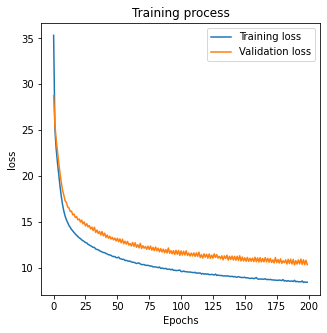

In [44]:
show_training_process(history=model_history, metric_name='loss',
                      figure_id=1)

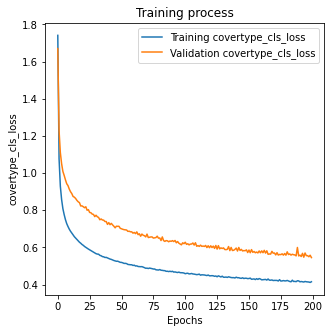

In [45]:
show_training_process(history=model_history, metric_name='covertype_cls_loss',
                      figure_id=2)

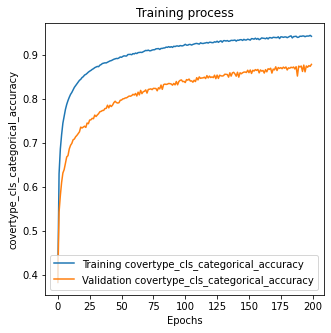

In [46]:
show_training_process(history=model_history,
                      metric_name='covertype_cls_categorical_accuracy',
                      figure_id=3)

In [47]:
del trainset_gen, validset_gen

In [48]:
del X_train, y_train, X_valid_quantized, X_train_quantized

In [49]:
del trainable_nn

In [50]:
gc.collect()

10899

In [51]:
valid_probas = predict_proba(
    X=X_valid, encoder=encoding_nn, classifier=classification_nn,
    n_samples=NUMBER_OF_SAMPLES, batch_size=MINIBATCH_SIZE_FOR_INFERENCE
)

  0%|          | 0/432 [00:00<?, ?it/s]

In [52]:
print(classification_report(y_true=y_valid, y_pred=np.argmax(valid_probas, axis=1),
                            digits=4))

              precision    recall  f1-score   support

           0     0.9086    0.8483    0.8774     10063
           1     0.9055    0.8749    0.8899     13457
           2     0.8789    0.9058    0.8921      1698
           3     0.4960    0.9645    0.6551       451
           4     0.6644    0.9285    0.7745       825
           5     0.7647    0.9877    0.8620       974
           6     0.7378    0.9237    0.8203       131

    accuracy                         0.8743     27599
   macro avg     0.7651    0.9190    0.8245     27599
weighted avg     0.8853    0.8743    0.8769     27599



In [53]:
test_probas = predict_proba(
    X=X_test, encoder=encoding_nn, classifier=classification_nn,
    n_samples=NUMBER_OF_SAMPLES, batch_size=MINIBATCH_SIZE_FOR_INFERENCE
)

  0%|          | 0/454 [00:00<?, ?it/s]

In [54]:
print(classification_report(y_true=y_test, y_pred=np.argmax(test_probas, axis=1),
                            digits=4))

              precision    recall  f1-score   support

           0     0.9051    0.8450    0.8740     10592
           1     0.9042    0.8751    0.8894     14165
           2     0.8876    0.9100    0.8986      1788
           3     0.5135    0.9579    0.6686       475
           4     0.6624    0.9516    0.7811       868
           5     0.7724    0.9922    0.8686      1026
           6     0.7633    0.9416    0.8431       137

    accuracy                         0.8744     29051
   macro avg     0.7726    0.9248    0.8319     29051
weighted avg     0.8846    0.8744    0.8766     29051

